##### Author: Roberto Lazzarini (4937188)

In [73]:
import pygame
import sys
import random
import numpy as np
import warnings
import matplotlib.pyplot as plt
from collections import deque

# DSIP - Final Project

# Constants

In [74]:
WIDTH, HEIGHT = 1200, 600
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
POOL_GREEN = (21, 88, 67)
BALL_COLOR = BLACK
BALL_RADIUS = 15


# Utility functions

In [75]:
def normalizeColor(color):
    return tuple([c / 255 for c in color])

# Classes

## Ball

In [76]:
class Ball:
    ### Initialization
    def __init__(self, x, y, radius, color):
        self.pos = [x, y]
        self.velocity = [0, 0]
        self.radius = radius
        self.color = color

    ### Movement calculations
    def apply_velocity(self, delta_t=1):
        self.pos[0] += self.velocity[0] * delta_t
        self.pos[1] += self.velocity[1] * delta_t
    def apply_friction(self, friction):
        self.velocity[0] *= friction
        self.velocity[1] *= friction

    ### Bouncing behaviour
    def is_touching__left_side_table(self):
        return self.pos[0] <= self.radius
    def is_touching__right_side_table(self):
        return self.pos[0] >= WIDTH - self.radius
    def bounce_horizontally(self):
        self.velocity[0] = -self.velocity[0]
    def is_touching__upper_side_table(self): 
        return self.pos[1] <= self.radius
    def is_touching__lower_side_table(self):
        return self.pos[1] >= HEIGHT - self.radius
    def bounce_vertically(self):
        self.velocity[1] = -self.velocity[1]
    def handle_bouncing(self):
        if self.is_touching__left_side_table() or self.is_touching__right_side_table():
            self.bounce_horizontally()
        if self.is_touching__upper_side_table() or self.is_touching__lower_side_table():
            self.bounce_vertically()

    ### Boundary handling
    def keep_within_screen(self):
        self.pos[0] = max(self.radius, min(WIDTH - self.radius, self.pos[0]))
        self.pos[1] = max(self.radius, min(HEIGHT - self.radius, self.pos[1]))

    ### Update
    def update(self, is_dragging, friction):  
        if not is_dragging:
            self.apply_velocity()
            self.apply_friction(friction)
            self.handle_bouncing()
            self.keep_within_screen()

    ### Drawing
    def draw(self, screen):
        pygame.draw.circle(screen, self.color, (int(self.pos[0]), int(self.pos[1])), self.radius)


## Sampler

In [77]:
class Sampler:
    def __init__(self, sigma_noise=5, buffer_size=100):
        self.samples = deque(maxlen=buffer_size) # using cicrular buffer to throw away old samples
        self.sigma_noise = sigma_noise

    def sample(self, ball):
        x_noisy = ball.pos[0] + random.gauss(0, self.sigma_noise)
        y_noisy = ball.pos[1] + random.gauss(0, self.sigma_noise)
        noisy_pos = [x_noisy, y_noisy]
        self.samples.append(noisy_pos)
        return noisy_pos

    def get_latest_sample(self):
        return self.samples[-1] if self.samples else None
    


## Kalman Filter

The update-predict flow is similar but not equal to the one discussed in the notes. Notably, the update step is performed whenever a new sample is available, which follows the `sample_rate` variable. For this reason, many predict steps (1 each frame, so 1 each 16ms, so `sample_rate/16`) are performed sequentially.

The algorithm that follows is the algorithm used by the simulation. The increment in time by 16 are due to the frame-centric nature of the simulation: time itself is measured and counted in milliseconds, but a new frame is drawn each $1/60$ of a second, so 16ms.


`if t==k*sample_rate`

1. Acquire the $t$-th measurement: $m_t$

2. Set the Kalman gain: $K_t = P_t^- H^\top (HP_t^- H^\top + R)^{-1}$

3. State update: $\hat{s}_t = \hat{s}_t^- + K_t(m_t - H\hat{s}_t^-)$

4. Covariance update: $P_t = (I - K_tH)P_t^-$ 

>4.5. $\hat{s}_t^- = \hat{s}_t"$

   `for 0 < i < sample_rate`
   
   5. State estimate projection: $\hat{s}_{t+i+16}^- = \Phi \hat{s}_{t+i}^-$

   6. Covariance estimate projection: $P_{t+i+16}^- = \Phi P_{t+i}^- \Phi^\top + Q$

   >6.5. $i \gets i + 16$

   >6.6. $t \gets t+i$



In [78]:
class KalmanFilter:
    def __init__(self, Q_matrix, sigma_noise, variance_exponent=2, ball_x=0, ball_y=0):
        # State vector: [x, y, vx, vy]
        self.state = np.array([ball_x, ball_y, 0.0, 0.0]) # s_hat (post-measurements)
        self.prediction = self.state.copy() # s_hat minus (pre-measurements)
        
        # Transition matrix
        self.Phi = np.array([
            [1, 0, 1, 0],
            [0, 1, 0, 1],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ])
        
        # Measurement matrix
        self.H = np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0]
        ])
        
        # Process noise covariance matrix
        self.Q = Q_matrix
        if self.Q is None: self.Q = np.diag([5.0, 5.0, 0.05, 0.05])
        
        # Measurement noise covariance matrix (the lower the value, the more the filter trusts the measurements)
        noise_variance = sigma_noise**variance_exponent
        self.R = np.eye(2) * noise_variance 
        
        # Error covariance matrix
        self.P = np.eye(4) # initialised as identity matrix
        
        self.state_estimate_position = None
        self.prediction_position = None

    def update(self, measurement): # 1. acquire the t-th measurement
        K = self.P @ self.H.T @ np.linalg.inv(self.H @ self.P @ self.H.T + self.R) # 2. set the Kalman gain
        innovation = measurement - (self.H @ self.prediction)
        self.state = self.prediction + (K @ innovation) # 3. State update
        self.P = (np.eye(4) - K @ self.H) @ self.P # 4. Covariance update
        self.state_estimate_position = self.state[:2] # (phantom step: isolate state estimate position for drawing)
        
        self.prediction = self.state.copy() # (this allows me use phi*pred instead of phi*state in step 5)
        # print(f'1: K={K} \n 2: innovation={innovation} \n 3: state={self.state} \n 4: P={self.P})')
        
    def predict(self):
        self.prediction = self.Phi @ self.prediction   # 5. State estimate projection (its phi*pred and not phi*state because i predict multiple frames ahead)
        self.P = self.Phi @ self.P @ self.Phi.T + self.Q # 6. Covariance estimate projection
        self.prediction_position = self.prediction[:2] # (phantom step: isolate prediction position for drawing)


### Alternative implementation 

(that does not bother to seprate between self.state and self.prediction)

In [79]:

# class KalmanFilter:
#     def __init__(self, Q_matrix, sigma_noise):
#         # State vector: [x, y, vx, vy]
#         self.state = np.array([0.0, 0.0, 0.0, 0.0])
#         # Transition matrix
#         self.Phi = np.array([
#             [1, 0, 1, 0],
#             [0, 1, 0, 1],
#             [0, 0, 1, 0],
#             [0, 0, 0, 1]
#         ])
#         # Measurement matrix
#         self.H = np.array([
#             [1, 0, 0, 0],
#             [0, 1, 0, 0]
#         ])
#         # Process noise covariance matrix
#         self.Q = Q_matrix
#         # Measurement noise covariance matrix (the lower the value, the more the filter trusts the measurements)
#         self.R = np.eye(2) * sigma_noise**2
#         # Error covariance matrix
#         self.P = np.eye(4) # initialised as identity matrix
        
#         self.state_estimate_position = None
#         self.prediction_position = None

#     def update(self, measurement): # 1. acquire the t-th measurement
#         K = self.P @ self.H.T @ np.linalg.inv(self.H @ self.P @ self.H.T + self.R) # 2. set the Kalman gain
#         innovation = measurement - (self.H @ self.state)
#         self.state = self.state + (K @ innovation) # 3. State update
#         self.P = (np.eye(4) - K @ self.H) @ self.P # 4. Covariance update
#         self.state_estimate_position = self.state[:2] # (phantom step: isolate state estimate position for drawing)
        
#         # print(f'1: K={K} \n 2: innovation={innovation} \n 3: state={self.state} \n 4: P={self.P})')
        
#     def predict(self):
#         self.state = self.Phi @ self.state # 5. State estimate projection
#         self.P = self.Phi @ self.P @ self.Phi.T + self.Q # 6. Covariance estimate projection
#         self.prediction_position = self.state[:2] # (phantom step: isolate prediction position for drawing)


## Data gathering

### Data collector

In [80]:
class DataCollector:
    def __init__(self):
        self.data = {
            "actual": [],
            "estimated": [],
            "predicted": [],
            "noisy": [],
            "absolute_error_estimated": [],
            "absolute_error_predicted": [],
        }

    def absolute_error(self, vect1, vect2):
        return np.linalg.norm(np.abs(np.array(vect1) - np.array(vect2)))
    
    def record(self, actual, estimated, predicted, noisy):
        self.data["actual"].append(actual)
        self.data["estimated"].append(estimated)
        self.data["predicted"].append(predicted)
        self.data["noisy"].append(noisy)
        self.data["absolute_error_estimated"].append(self.absolute_error(actual, estimated))
        self.data["absolute_error_predicted"].append(self.absolute_error(actual, predicted))
        
    def get_data(self):
        return self.data


### Data analyzer

In [81]:
class DataAnalyzer:
    @staticmethod
    def calculate_mae(errors):
        return np.mean(errors)

    @staticmethod
    def percentage_within_threshold(errors, threshold):
        within_threshold = [e for e in errors if e <= threshold]
        return (len(within_threshold) / len(errors)) * 100

### Data visualizer

In [82]:
class DataVisualizer:
    @staticmethod
    def print_errors(data):
        estimated_errors = np.array(data["absolute_error_estimated"])
        error_predicted = np.array(data["absolute_error_predicted"])
        
        mae_estimated = DataAnalyzer.calculate_mae(estimated_errors)
        mae_predicted = DataAnalyzer.calculate_mae(error_predicted)
        print(f"\nEstimated: - Mean Absolute Error (MAE):{mae_estimated:.2f} px")
        print(f"Predicted: - Mean Absolute Error (MAE):{mae_predicted:.2f} px")

    @staticmethod
    def print_percentage_under_threshold(data, threshold=10):
        estimated_errors = np.array(data["absolute_error_estimated"])
        error_predicted = np.array(data["absolute_error_predicted"])
        
        percentage_estimated = DataAnalyzer.percentage_within_threshold(estimated_errors, threshold)
        percentage_predicted = DataAnalyzer.percentage_within_threshold(error_predicted, threshold)
        print(f"Estimated: - percentage under {threshold} px from the actual state: {percentage_estimated:.2f}%")
        print(f"Predicted: - percentage under {threshold} px from the actual state: {percentage_predicted:.2f}%")    
        
    @staticmethod
    def plot_trails(data):
        actual = np.array(data["actual"])
        estimated = np.array(data["estimated"])
        predicted = np.array(data["predicted"])
        noisy = np.array(data["noisy"])

        plt.figure(figsize=(10, 6))
        
        # Draw the background rectangle
        plt.gca().add_patch(plt.Rectangle((0, 0), WIDTH, HEIGHT, color=normalizeColor(POOL_GREEN), zorder=0))
        
        # Plot trails
        plt.plot(actual[:, 0], actual[:, 1], label="Actual", color="black", zorder=1)
        plt.plot(estimated[:, 0], estimated[:, 1], label="Estimated", color="green", zorder=2)
        plt.plot(predicted[:, 0], predicted[:, 1], label="Predicted", color="blue", zorder=2)
        plt.scatter(noisy[:, 0], noisy[:, 1], label="Noisy", color="red", s=10, alpha=0.5, zorder=3)
        
        # legend
        plt.legend()
        plt.xlabel("X Position")
        plt.ylabel("Y Position")
        plt.title("Trails of Actual, Estimated, Predicted, and Noisy Positions")
        plt.xlim(0, WIDTH)
        plt.ylim(0, HEIGHT)
        plt.gca().set_aspect('equal', adjustable='box')  # Maintain aspect ratio
        plt.gca().invert_yaxis()  # Invert Y-axis to place the origin at the top-left
        plt.show()



    @staticmethod
    def plot_errors(estimated_errors, error_predicted):
        plt.figure(figsize=(18, 6))
        plt.plot(estimated_errors, label="Estimated Error", color="green")
        plt.plot(error_predicted, label="Predicted Error", color="blue")
        plt.xlabel("Frame")
        plt.ylabel("Error")
        plt.title("Errors over Time")
        plt.legend()
        plt.show()



## Game simulation

The game siimulation follows the following architecture

- Game: orchestrate the elements and updates
    - GameContext
    - GameEventManager
    - GameRenderer
    - GameStateManager

The information flows in this pattern:
- GameContext ⟷  Game
- GameContext ⟷  EventManager
- GameContext ⟷  Renderer
- GameContext ⟷ GameStateManager   

The isolation of the game state in GameContext makes possible to avoid circular referencing (A imports B which imports A).

In [83]:
class Game:
    def __init__(self, sample_rate=750, friction=1.0, sigma_noise=5, speed_factor=1.0, buffer_size=100, Q_matrix=None, variance_exponent=2):
        self.context = GameContext(
            sample_rate=sample_rate,
            friction=friction,
            sigma_noise=sigma_noise,
            speed_factor=speed_factor,
            buffer_size=buffer_size,
            Q_matrix=Q_matrix,
            variance_exponent=variance_exponent
        )
        self.renderer = GameRenderer(self.context)
        self.state_manager = GameStateManager(self.context)
        self.event_manager = GameEventMangager(self.context, self.state_manager.update, self.renderer.draw)

        # Game clock
        self.clock = pygame.time.Clock()

    ### Game loop
    def run(self):
        while self.context.running:
            self.event_manager.handle_events()
            if not self.context.paused:
                self.state_manager.update()
            self.renderer.draw()
            self.clock.tick(int(60 * self.context.speed_factor))
        pygame.quit()
        sys.exit()


In [84]:
class GameContext:
    def __init__(self, sample_rate, friction, sigma_noise, speed_factor, buffer_size, Q_matrix, variance_exponent):
        # Ball State
        self.ball = self.initialize_ball()

        # Simulation Settings
        self.friction = friction
        self.speed_factor = max(0.1, min(speed_factor, 1.0))  # Clamp speed_factor between 0.1 and 1.0

        # Kalman Filter and Sampling
        self.sample_rate = sample_rate
        self.sampler = Sampler(sigma_noise=sigma_noise, buffer_size=buffer_size)
        self.kalman_filter = KalmanFilter(
            Q_matrix=Q_matrix,
            sigma_noise=sigma_noise,
            variance_exponent=variance_exponent,
            ball_x=self.ball.pos[0],
            ball_y=self.ball.pos[1]
        )
        self.data_collector = DataCollector()
        self.last_sample_time = 0
        self.simulated_time = 0

        # Screen
        self.screen = self.initialize_screen()

        # Game Control
        self.running = True
        self.paused = False
        self.is_dragging = False
        self.mouse_pos = None

    def initialize_ball(self):
        x = random.randint(BALL_RADIUS, WIDTH - BALL_RADIUS)
        y = random.randint(BALL_RADIUS, HEIGHT - BALL_RADIUS)
        return Ball(x, y, BALL_RADIUS, BALL_COLOR)

    def initialize_screen(self):
        pygame.init()
        screen = pygame.display.set_mode((WIDTH, HEIGHT))
        pygame.display.set_caption("Kalman Filter 8-Ball Pool")
        return screen

    def now(self):
        return pygame.time.get_ticks()

In [85]:
class GameRenderer:
    def __init__(self, context):
        self.context = context
    
    def draw_ball(self):
        self.context.ball.draw(self.context.screen)

    def draw_drag_indicator(self):
        if self.context.is_dragging and self.context.mouse_pos:
            # Draw a small white dot at the current mouse position
            pygame.draw.circle(self.context.screen, WHITE, (int(self.context.mouse_pos[0]), int(self.context.mouse_pos[1])), 5)
            # Draw a line indicating drag direction
            outward_point = (self.context.ball.pos[0] + (self.context.ball.pos[0] - self.context.mouse_pos[0]), self.context.ball.pos[1] + (self.context.ball.pos[1] - self.context.mouse_pos[1]))
            pygame.draw.line(
                self.context.screen, WHITE, 
                (int(self.context.ball.pos[0]), int(self.context.ball.pos[1])), 
                outward_point, 
                width=2
            )
            velocity_x = (self.context.ball.pos[0] - self.context.mouse_pos[0]) * 0.1
            velocity_y = (self.context.ball.pos[1] - self.context.mouse_pos[1]) * 0.1
            velocity_norm = (velocity_x**2 + velocity_y**2)**0.5
            
            font = pygame.font.Font(None, 24)
            speed_text = font.render(f"Speed: {velocity_norm:.2f} px/frame", True, WHITE)
            self.context.screen.blit(speed_text, (WIDTH - 150, 20))

    def draw_latest_sample(self):
        latest_sample = self.context.sampler.get_latest_sample()
        if latest_sample:
            pygame.draw.circle(self.context.screen, (255, 0, 0),
                            (int(latest_sample[0]), int(latest_sample[1])), 5)

    def draw_predicted_state(self):
        if self.context.kalman_filter.prediction_position is not None:
            prediction_coordinates = (int(self.context.kalman_filter.prediction_position[0]), int(self.context.kalman_filter.prediction_position[1]))
            pygame.draw.circle(self.context.screen, (0, 0, 255), prediction_coordinates, BALL_RADIUS, 2)

    def draw_state_estimate_position(self):
        if self.context.kalman_filter.state_estimate_position is not None:
            pygame.draw.circle(self.context.screen, (0, 255, 0),
                            (int(self.context.kalman_filter.state_estimate_position[0]), int(self.context.kalman_filter.state_estimate_position[1])), 5)

    def draw_overlay(self):
        # Play/Pause button
        pygame.draw.rect(self.context.screen, BLACK, (20, 20, 50, 30))
        font = pygame.font.Font(None, 24)
        text = font.render("Play" if self.context.paused else "Stop", True, WHITE)
        self.context.screen.blit(text, (25, 25))
        pygame.draw.rect(self.context.screen, BLACK, (80, 20, 50, 30))
        text = font.render("Step", True, WHITE)
        self.context.screen.blit(text, (85, 25))
        
        # Legend
        legend_y = 60
        legend_items = [
            ("Actual state", BALL_COLOR),
            ("State estimate", (0, 255, 0)),
            ("Measurement", (255, 0, 0)),
            ("State prediction", (0, 0, 255))
        ]
        for item, color in legend_items:
            pygame.draw.rect(self.context.screen, color, (20, legend_y, 10, 10))
            text = font.render(item, True, BLACK)
            self.context.screen.blit(text, (40, legend_y - 5))
            legend_y += 20

    def draw(self):
        self.context.screen.fill(POOL_GREEN)
        self.draw_ball()
        self.draw_drag_indicator()
        self.draw_latest_sample()
        self.draw_predicted_state()
        self.draw_state_estimate_position()
        self.draw_overlay()
        pygame.display.flip()

In [86]:
class GameEventMangager:
    def __init__(self, context, update_callback, draw_callback):
        self.context = context
        self.update = update_callback
        self.draw = draw_callback
        
    def is_clicking_play_pause_button(self, mouse_x, mouse_y):
        return 20 <= mouse_x <= 70 and 20 <= mouse_y <= 50

    def is_clicking_step_button(self, mouse_x, mouse_y):
        return 80 <= mouse_x <= 130 and 20 <= mouse_y <= 50
    
    def is_clicking_ball(self, mouse_x, mouse_y):
        return ((mouse_x - self.context.ball.pos[0])**2 + (mouse_y - self.context.ball.pos[1])**2)**0.5 <= self.context.ball.radius
    
    def release_ball(self, event):
        # computing distance between mouse and ball
        mouse_x, mouse_y = event.pos
        ball_x, ball_y = self.context.ball.pos
        dx = mouse_x - ball_x
        dy = mouse_y - ball_y
        # computing ball velocity vector
        scaling_factor = 0.1
        vx = -dx * scaling_factor # negative sign to make the ball move opposite to the mouse
        vy = -dy * scaling_factor # negative sign to make the ball move opposite to the mouse
        self.context.ball.velocity = [vx, vy]
        # reset dragging state
        self.context.is_dragging = False
        self.context.mouse_pos = None  # Reset mouse position

    def visualize_data(self):
        # collecting data
        data = self.context.data_collector.get_data()
        # visualize
        visualizer = DataVisualizer()        
        visualizer.print_errors(data)
        visualizer.print_percentage_under_threshold(data, threshold=10)
        visualizer.plot_trails(data)
        visualizer.plot_errors(data["absolute_error_estimated"],data["absolute_error_predicted"])
        
    def handle_events(self):
        for event in pygame.event.get():
            match event.type:
                
                case pygame.QUIT:
                    self.context.running = False
                    self.visualize_data()
                    
                case pygame.MOUSEBUTTONDOWN:
                    mouse_x, mouse_y = pygame.mouse.get_pos()
                    if self.is_clicking_play_pause_button(mouse_x, mouse_y): 
                        self.context.paused = not self.context.paused
                        self.context.simulated_time = self.context.now()
                    elif self.is_clicking_step_button(mouse_x, mouse_y) and self.context.paused: 
                        step_duration = int(16 * (1 / self.context.speed_factor))  # Simulate 16 ms (a single frame)
                        self.context.simulated_time = self.context.simulated_time + step_duration       
                        self.update(timeStamp=self.context.simulated_time)
                        self.draw()
                    elif self.is_clicking_ball(mouse_x, mouse_y):
                        self.context.is_dragging = True
                        
                case pygame.MOUSEBUTTONUP:
                    if self.context.is_dragging:
                        self.release_ball(event)

                case pygame.MOUSEMOTION:
                    if self.context.is_dragging:
                        self.context.mouse_pos = event.pos  # Update mouse position when dragging

In [87]:
class GameStateManager:
    def __init__(self, context):
        self.context = context
        
    def is_new_sample_available(self, timeStamp=None):
        return (timeStamp - self.context.last_sample_time >= self.context.sample_rate)
    
    def update(self, timeStamp=None):
        # Updating ball position and prediction (frame-by-frame)
        self.context.ball.update(self.context.is_dragging, self.context.friction)
        self.context.kalman_filter.predict()
        
        # Collecting a new sample and updating the filter (following the sample rate)
        if timeStamp is None: timeStamp = self.context.now() 
        if self.is_new_sample_available(timeStamp=timeStamp):
            noisy_pos = self.context.sampler.sample(self.context.ball)
            measurement = np.array([noisy_pos[0], noisy_pos[1]])
            self.context.kalman_filter.update(measurement)
            self.context.last_sample_time = timeStamp
            # Recording data for analysis
            self.context.data_collector.record(
                actual=np.array(self.context.ball.pos),
                estimated=self.context.kalman_filter.state_estimate_position,
                predicted=self.context.kalman_filter.prediction_position,
                noisy=noisy_pos
            )

# Main

In [88]:
def initialize_Q(position_variance, velocity_variance):
    return np.diag([position_variance, position_variance, velocity_variance, velocity_variance])

In [89]:
# scenario 1: many samples, high noise - you can go fast
frame_length = 16
sample_rate = 8 * frame_length
sigma_noise = 10

# Q_matrix = np.diag([5.0, 5.0, 0.05, 0.05])
process_noise_variance_exponent = 4
measurement_noise_variance_exponent = 2 # the higher the value the more trust in process model (so: good if the ball moves slowly, worsens performance in bounces)
Q_matrix = initialize_Q(2*process_noise_variance_exponent, 1)



# scenario 2: few samples, low noise
# frame_length = 16
# sample_rate = 30 * frame_length # 500 ms
# sigma_noise = 5

# process_noise_variance_exponent = 4
# measurement_noise_variance_exponent = 2
# Q_matrix = initialize_Q(sigma_noise**process_noise_variance_exponent, 1)


Estimated: - Mean Absolute Error (MAE):9.87 px
Predicted: - Mean Absolute Error (MAE):18.91 px
Estimated: - percentage under 10 px from the actual state: 58.70%
Predicted: - percentage under 10 px from the actual state: 32.61%


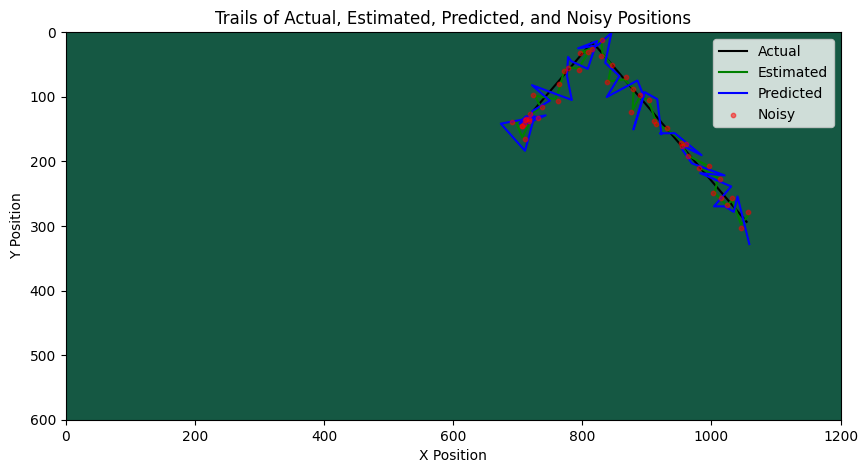

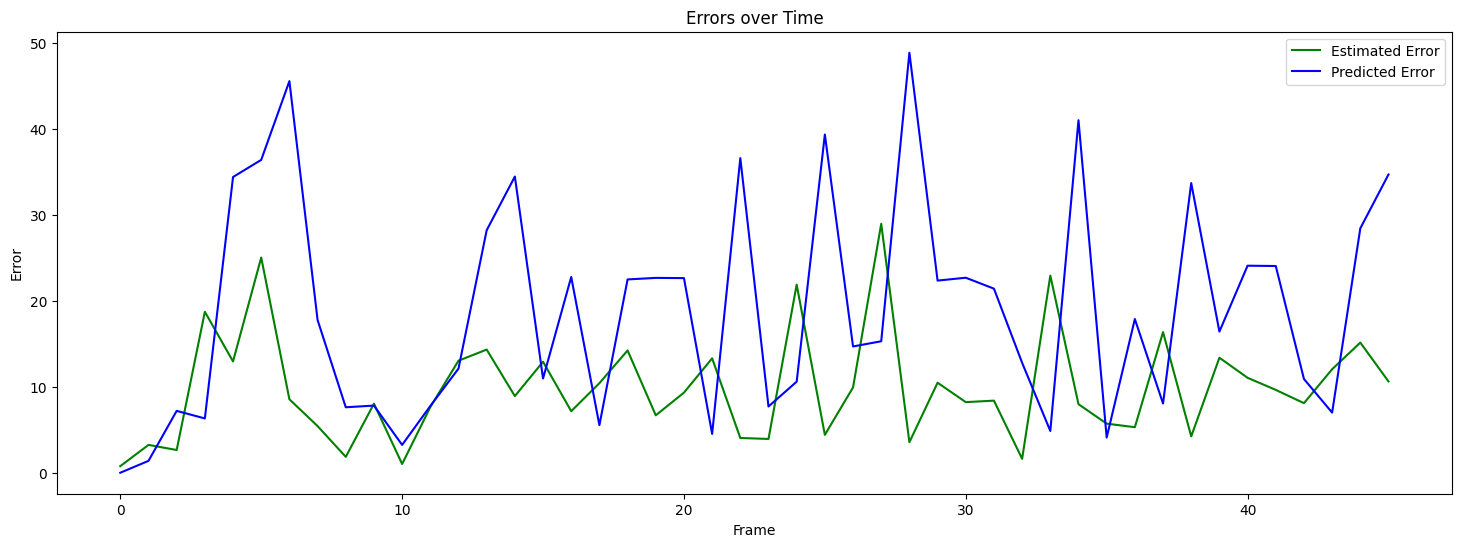

SystemExit: 

c:\Users\nonce\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3441: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [90]:

game = Game(sample_rate=sample_rate, friction=1, 
            sigma_noise=sigma_noise, Q_matrix=Q_matrix, variance_exponent=measurement_noise_variance_exponent)
game.run()
